In [25]:
import ast
import json
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import chain
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Read data

In [43]:
# Load the pickled list
with open("/Utilisateurs/umushtaq/emotion_analysis_comics/incontext_learning/results/icl_llama-3-8b-Instruct-bnb-4bit/results_10.pickle", 'rb') as f:
    
    results = pickle.load(f)

In [44]:
all_labels = ["anger", "surprise", "fear", "disgust", "sadness", "joy", "neutral"]

In [45]:
grounds = results['ground_truths']
predictions = results['predictions']

In [29]:
def labels_to_binary_matrix(label_list, all_labels):
    binary_matrix = np.zeros((len(label_list), len(all_labels)))
    
    for i, labels in enumerate(label_list):
        for label in labels:
            if label in all_labels:
                binary_matrix[i][all_labels.index(label)] = 1
                
    return binary_matrix

def opposite(component_type):

    if component_type == "anger":
        return "surprise"
    elif component_type == "disgust":
        return "joy"
    elif component_type == "fear":
        return "sadness"
    elif component_type == "sadness":
        return "anger"
    elif component_type == "surprise":
        return "disgust"
    elif component_type == "joy":
        return "fear"
    elif component_type == "Neutral":
        return "sadness"
    

def harmonize_preds(grounds, preds):

    l1, l2 = len(preds), len(grounds)
    if l1 < l2:
        diff = l2 - l1
        preds = preds + [opposite(x) for x in grounds[l1:]]
    else:
        preds = preds[:l2]
        
    return preds 

def post_process_icl(grounds, preds):

    for i,(x,y) in enumerate(zip(grounds, preds)):
        
        if len(x) != len(y):
            
            preds[i] = harmonize_preds(x, y)

    true_matrix = labels_to_binary_matrix(grounds, all_labels)
    predicted_matrix = labels_to_binary_matrix(preds, all_labels)

    return true_matrix, predicted_matrix

In [30]:
true_matrix, predicted_matrix = post_process_icl(grounds, predictions)

## Classification Report

In [31]:
print(classification_report(true_matrix, predicted_matrix, target_names=all_labels, digits=3))

              precision    recall  f1-score   support

       anger      0.640     0.521     0.575       614
    surprise      0.539     0.712     0.613       486
        fear      0.475     0.396     0.432       407
     disgust      0.192     0.376     0.254        85
     sadness      0.478     0.317     0.381       347
         joy      0.568     0.557     0.562       429
     neutral      0.181     0.248     0.209       129

   micro avg      0.501     0.497     0.499      2497
   macro avg      0.439     0.447     0.432      2497
weighted avg      0.520     0.497     0.500      2497
 samples avg      0.480     0.477     0.478      2497



/Utilisateurs/umushtaq/.conda/envs/er_nb_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix

In [32]:
def get_confusion_matrices(grounds, predictions, all_labels):
    # Create a dictionary to map allowed labels to indices
    label_to_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Initialize one-hot encoded arrays for ground truths and predictions
    y_true = np.zeros((len(grounds), len(all_labels)), dtype=int)
    y_pred = np.zeros((len(predictions), len(all_labels)), dtype=int)
    
    # One-hot encode the ground truths (use only allowed labels)
    for i, labels in enumerate(grounds):
        for label in labels:
            if label in label_to_index:
                y_true[i][label_to_index[label]] = 1
    
    # One-hot encode the predictions, setting any unallowed label as false (0)
    for i, labels in enumerate(predictions):
        for label in labels:
            if label in label_to_index:
                y_pred[i][label_to_index[label]] = 1
    
    # Generate confusion matrices for each label in the desired structure
    confusion_matrices = {}
    for label, idx in label_to_index.items():
        # Get the confusion matrix from sklearn
        cm = confusion_matrix(y_true[:, idx], y_pred[:, idx])
        
        # Rearrange the confusion matrix to the requested structure: TP FP, FN TN
        tp = cm[1, 1]  # True Positive
        fp = cm[0, 1]  # False Positive
        fn = cm[1, 0]  # False Negative
        tn = cm[0, 0]  # True Negative
        
        # Create a matrix with the desired structure
        rearranged_cm = np.array([[tp, fp], [fn, tn]])
        confusion_matrices[label] = rearranged_cm
    
    return confusion_matrices

In [33]:
confusion_matrices = get_confusion_matrices(grounds, predictions, all_labels)

In [34]:
for label, cm in confusion_matrices.items():
    print(f"Confusion Matrix for label '{label}':\n{cm}\n")

Confusion Matrix for label 'anger':
[[320 180]
 [294 982]]

Confusion Matrix for label 'surprise':
[[346 296]
 [140 994]]

Confusion Matrix for label 'fear':
[[ 161  178]
 [ 246 1191]]

Confusion Matrix for label 'disgust':
[[  32  135]
 [  53 1556]]

Confusion Matrix for label 'sadness':
[[ 110  120]
 [ 237 1309]]

Confusion Matrix for label 'joy':
[[ 239  182]
 [ 190 1165]]

Confusion Matrix for label 'neutral':
[[  32  145]
 [  97 1502]]



### Plots

In [35]:
def plot_confusion_matrices(confusion_matrices, all_labels):
    # Set up a grid for plotting confusion matrices
    num_labels = len(all_labels)
    fig, axes = plt.subplots(1, num_labels, figsize=(4 * num_labels, 4))
    
    if num_labels == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    # Plot each confusion matrix
    for i, (label, cm) in enumerate(confusion_matrices.items()):
        # Create a heatmap for the confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
        
        # Set titles and labels
        axes[i].set_title(f'Confusion Matrix: {label}', fontsize=12)
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_ylabel('Actual', fontsize=10)
        
        # Customize x and y ticks
        axes[i].set_xticklabels(['Positive', 'Negative'])
        axes[i].set_yticklabels(['Positive', 'Negative'], rotation=0)
    
    plt.tight_layout()
    plt.show()

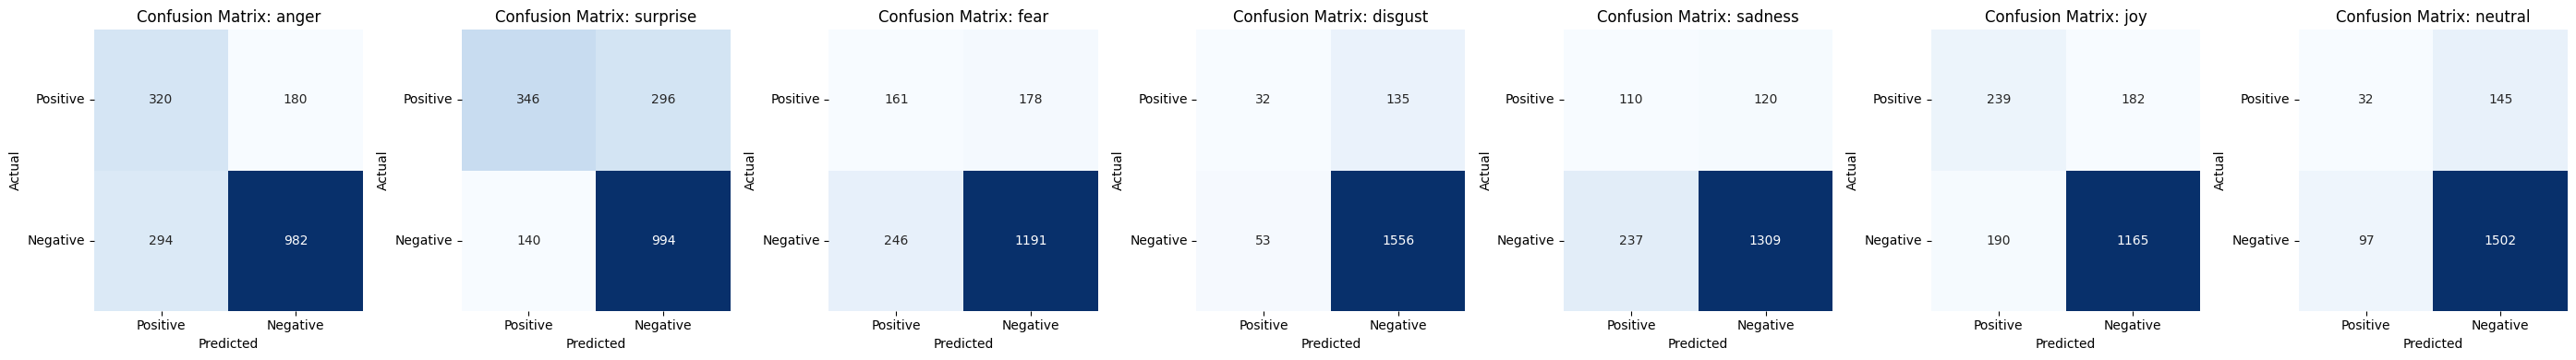

In [36]:
plot_confusion_matrices(confusion_matrices, all_labels)

In [52]:
def get_flattened_labels(grounds, predictions, all_labels):
    """
    Convert multi-label data into flat arrays of class indices.
    """
    y_true_flat = []
    y_pred_flat = []
    
    # Create a mapping from labels to indices
    label_to_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Flatten y_true and y_pred into class indices
    for true_labels, pred_labels in zip(grounds, predictions):
        true_one_hot = [0] * len(all_labels)
        pred_one_hot = [0] * len(all_labels)
        
        for label in true_labels:
            if label in label_to_index:
                true_one_hot[label_to_index[label]] = 1
        
        for label in pred_labels:
            if label in label_to_index:
                pred_one_hot[label_to_index[label]] = 1
        
        # Append the indices for the predicted and true labels
        y_true_flat.append(true_one_hot)
        y_pred_flat.append(pred_one_hot)
    
    return np.array(y_true_flat), np.array(y_pred_flat)

def plot_multi_class_confusion_matrix(y_true, y_pred, all_labels):
    """
    Plot a multi-class confusion matrix using the true and predicted labels.
    """
    # Flatten the multi-label arrays into single-label arrays
    y_true_flat = np.argmax(y_true, axis=1)
    y_pred_flat = np.argmax(y_pred, axis=1)

    # Compute the confusion matrix for multi-class classification
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
    
    # Set labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Multi-Class Confusion Matrix')
    plt.show()


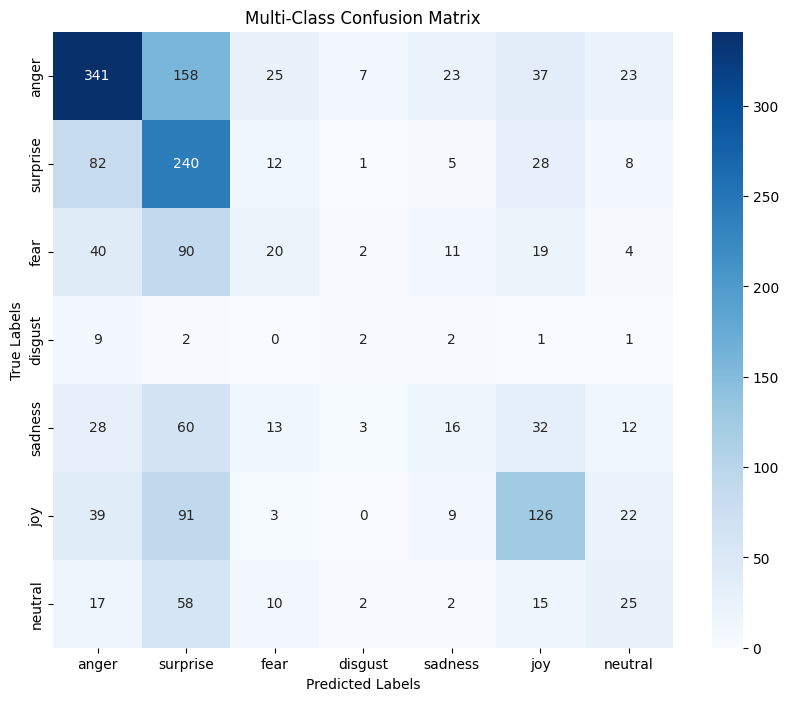

In [53]:
# Convert multi-label ground truth and predictions into flat labels
y_true, y_pred = get_flattened_labels(grounds, predictions, all_labels)

# Plot the multi-class confusion matrix
plot_multi_class_confusion_matrix(y_true, y_pred, all_labels)


In [47]:
from collections import Counter

def count_labels(grounds, all_labels):
    # Flatten the list of lists into a single list of labels
    all_true_labels = list(chain.from_iterable(grounds))
    
    # Use Counter to count occurrences of each label
    label_counts = Counter(all_true_labels)
    
    # Display counts for all labels in all_labels
    counts_display = {label: label_counts.get(label, 0) for label in all_labels}
    
    return counts_display



In [48]:
label_counts = count_labels(grounds, all_labels)

# Print the counts
for label, count in label_counts.items():
    print(f"Label '{label}': {count}")

Label 'anger': 614
Label 'surprise': 486
Label 'fear': 407
Label 'disgust': 85
Label 'sadness': 347
Label 'joy': 429
Label 'neutral': 129


In [49]:
from collections import Counter
from itertools import chain

def count_labels(predictions, all_labels):
    # Flatten the list of lists into a single list of labels
    all_predicted_labels = list(chain.from_iterable(predictions))
    
    # Use Counter to count occurrences of each label
    label_counts = Counter(all_predicted_labels)
    
    # Display counts for all labels in all_labels, ignoring any extra labels
    counts_display = {label: label_counts.get(label, 0) for label in all_labels}
    
    return counts_display

# Example usage
all_labels = ["anger", "surprise", "fear", "disgust", "sadness", "joy", "neutral"]
#predictions = [['joy', 'happiness'], ['fear'], ['sadness', 'disgust'], ['neutral', 'fear', 'excitement']]




In [50]:
label_counts = count_labels(predictions, all_labels)

# Print the counts
for label, count in label_counts.items():
    print(f"Label '{label}': {count}")

Label 'anger': 556
Label 'surprise': 919
Label 'fear': 433
Label 'disgust': 191
Label 'sadness': 335
Label 'joy': 575
Label 'neutral': 253
